In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import imageio


In [23]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import imageio

def run_env():

    # Initialize the environment
    env = gym.make("CartPole-v1", render_mode=None)

    # Arrays to store state values for each dimension
    cart_positions = []
    cart_velocities = []
    pole_angles = []
    pole_angular_velocities = []

    # Number of episodes to run
    num_episodes = 100000

    for episode in range(num_episodes):
        observation, info = env.reset(seed=42 + episode)
        while True:
            # Sample a random action (this can be replaced with a policy)
            action = env.action_space.sample()
            
            # Step through the environment
            observation, reward, terminated, truncated, info = env.step(action)
            
            # Store each state component into respective arrays
            cart_positions.append(observation[0])       # Cart position
            cart_velocities.append(observation[1])     # Cart velocity
            pole_angles.append(observation[2])         # Pole angle
            pole_angular_velocities.append(observation[3])  # Pole angular velocity

            # If the episode ends, reset the environment
            if terminated or truncated:
                break

    env.close()

    # Convert lists to numpy arrays for further processing
    cart_positions = np.array(cart_positions)
    cart_velocities = np.array(cart_velocities)
    pole_angles = np.array(pole_angles)
    pole_angular_velocities = np.array(pole_angular_velocities)

    # Calculate min and max for each state dimension
    ranges = {
        "cart_positions": (cart_positions.min(), cart_positions.max()),
        "cart_velocities": (cart_velocities.min(), cart_velocities.max()),
        "pole_angles": (pole_angles.min(), pole_angles.max()),
        "pole_angular_velocities": (pole_angular_velocities.min(), pole_angular_velocities.max()),
    }

    print(ranges)


class ParameterDecay:
    def __init__(self, initial_value, min_value, decay_rate, decay_type):
        self.value = initial_value
        self.min_value = min_value
        self.decay_rate = decay_rate
        self.initial_value = initial_value
        self.decay_type = decay_type
        
    def get_value(self, episode):
        if self.decay_type == 'exponential':
            self.value = max(
                self.min_value, 
                self.value * self.decay_rate
            )
        elif self.decay_type == 'linear':
            self.value = max(
                self.min_value,
                self.initial_value - (self.initial_value - self.min_value) * (episode / 1000)
            )
        elif self.decay_type == 'step':
            if episode % 100 == 0 and self.value > self.min_value:
                self.value = max(self.min_value, self.value * self.decay_rate)

        elif self.decay_type == 'none':
            self.value = self.value
            
        return self.value
    

class FourierFeatureGenerator:
    def __init__(self, n, num_states):
        # Generate all combinations of Fourier coefficients for the given dimensions
        self.coefficients = np.array(np.meshgrid(*[range(n + 1)] * num_states)).T.reshape(-1, num_states)

    # min-max scaling
    def normalize(self, value, min_val, max_val):
        return (value - min_val) / (max_val - min_val)

    # normalize between 0 to 1
    def sigmoid_normalization(self, x): 
        return 1 / (1 + np.exp(-x))

    def tanh_normalization(self, x):
        return 0.5 * (np.tanh(x) + 1)
        
    def bound(self, value, low, high):
        return max(low, min(value, high))
            
    def generate_features(self, cos_theta_1, cos_theta_2, v_theta_1, v_theta_2, num_actions):
        # bound
        # Assuming the limits for each state
        cos_theta_1_limits = (-1, 1)
        cos_theta_2_limits = (-1, 1)
        v_theta_1_limits = (-12.567, 12.567)
        v_theta_2_limits = (-28.274, 28.274)
        
        # Calling the bound function for each state
        cos_theta_1 = self.bound(cos_theta_1, cos_theta_1_limits[0], cos_theta_1_limits[1])
        cos_theta_2 = self.bound(cos_theta_2, cos_theta_2_limits[0], cos_theta_2_limits[1])

        v_theta_1 = self.bound(v_theta_1, v_theta_1_limits[0], v_theta_1_limits[1])
        v_theta_2 = self.bound(v_theta_2, v_theta_2_limits[0], v_theta_2_limits[1])

        # Normalize each state variable to the range [0, 1]
        cos_theta_1 = self.normalize(cos_theta_1, cos_theta_1_limits[0], cos_theta_1_limits[1])
        cos_theta_2 = self.normalize(cos_theta_2, cos_theta_2_limits[0], cos_theta_2_limits[1])

        v_theta_1 = self.normalize(v_theta_1, v_theta_1_limits[0], v_theta_1_limits[1])
        v_theta_2 = self.normalize(v_theta_2, v_theta_2_limits[0], v_theta_2_limits[1])
        
        # Normalizing with tanh
        # cart_vel = self.sigmoid_normalization(cart_vel)
        # pole_vel = self.sigmoid_normalization(pole_vel)
        
        # Compute the Fourier base features
        base_features = np.cos(
            np.pi * (
                self.coefficients[:, 0] * cos_theta_1 +
                self.coefficients[:, 1] * cos_theta_2 +
                self.coefficients[:, 2] * v_theta_1 +
                self.coefficients[:, 3] * v_theta_2
            )
        ) 

        return np.tile(base_features, num_actions)


# returns a single value, dot product of two vectors
def get_state_value(w, features): 
    return np.dot(w, features)

# returns a list of policy values for each action
def get_policy_values(theta, features, actions):

    d = len(features) // len(actions)
    log_policy_values = np.zeros(len(actions))
    for a in actions:
        log_policy_values[a] = np.dot(theta[a*d: (a+1)*d], features[a*d: (a+1)*d])
    
    log_policy_values -= np.max(log_policy_values)
    policy_values = np.exp(log_policy_values)
    
    assert not np.isinf(features).any(), "Features contain inf"
    assert not np.isnan(policy_values ).any(), "Policy numerator contain NaN"
        
    # print(f'policy_values {policy_values}')
    assert not np.isnan(policy_values / np.sum(policy_values)).any(), "Policy contain NaN"
    return policy_values / np.sum(policy_values)


def epsilon_greedy_policy(features, theta, epsilon, actions):
    policy_values = get_policy_values(theta, features, actions)
    return np.random.choice(actions, p=policy_values)


# list of one hot encoded features for each action like [0 X(s) 0] 
def get_feature_values_for_all_a(d, features, actions):
    feature_values = []
    feature_value = np.zeros(d * len(actions))
    
    d = len(features) // len(actions)
    for action in actions:
        feature_value[action * d:(action + 1) * d] = features[action * d:(action + 1) * d]
        feature_values.append(feature_value)
    return np.array(feature_values)


def actor_critic(env, num_episodes, alpha_decay_w, alpha_decay_theta, gamma, epsilon_decay, n, k, lambda_w, lambda_theta):
    feature_generator = FourierFeatureGenerator(n, k)
    d = (n + 1) ** k
    num_actions = 3
    torque_n_1, torque_0, torque_1  = [0, 1, 2]
    actions = np.array([torque_n_1, torque_0, torque_1])
    
    w = np.zeros(d * num_actions)
    theta = np.zeros(d * num_actions)
   
    frames = []
    
    returns = []
    steps = []
    
    for episode in range(num_episodes):
        # animation frames
        # initialize z vector for every step update 
        z_w = np.zeros(d * num_actions)
        z_theta = np.zeros(d * num_actions)
        I = 1
        
        state, _ = env.reset()
        total_reward = 0
        step_count = 0
        
        current_epsilon = epsilon_decay.get_value(episode)
        current_alpha_w = alpha_decay_w.get_value(episode)
        current_alpha_theta = alpha_decay_theta.get_value(episode)
        
        
        features = feature_generator.generate_features(
            state[0], state[2], state[4], state[5]
            , num_actions
        )
        # current_q = get_action_value(w, features)
        
        
        done = False
        while not done:
            action = epsilon_greedy_policy(features, theta, current_epsilon, actions)
            # add into animation
            if episode == (num_episodes-1):
                frames.append(env.render())
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated
            total_reward += reward
            step_count += 1
            
            next_features = feature_generator.generate_features(
                next_state[0], next_state[2], next_state[4], next_state[5]
                , num_actions
            )
            
            current_v = get_state_value(w, features)
            
            if done:
                td_error = reward - current_v
            else:
                # next_action = epsilon_greedy_policy(next_features, theta, current_epsilon, actions)
                next_v = get_state_value(w, next_features)
                td_error = reward + gamma * next_v - current_v

            xt = features[action * d:(action + 1) * d]
            # calculate z_w 
            zw_t = z_w[action * d:(action + 1) * d]
            zw_t = gamma*lambda_w*zw_t + xt
            z_w[action * d:(action + 1) * d] = zw_t

            # calculate z_theta
            xt_theta = np.zeros(d*num_actions)
            # one hot encoding
            xt_theta[action * d:(action + 1) * d] = features[action * d:(action + 1) * d]
            ztheta_t = z_theta # [() () ()]
            # calculating delta_ln(...)
            policy_values = get_policy_values(theta, features, actions)
            feature_values_for_all_a = get_feature_values_for_all_a(d, features, actions) 


            ml_pi_x = np.array([
                policy_values[i] * feature_values_for_all_a[i]
                for i in range(len(actions))
            ])

            result = sum(ml_pi_x)
            
            delta_ln = xt_theta - result
            
            ztheta_t = gamma * lambda_theta * ztheta_t + I * delta_ln
            z_theta = ztheta_t
            # print(f'ztheta_t {ztheta_t}')
            # w update
            w[action * d:(action + 1) * d] += current_alpha_w * td_error * zw_t
            # theta update
            theta += current_alpha_theta * td_error * ztheta_t

            if not done:
                state = next_state
                I = gamma * I
                features = next_features
                # action = next_action
        
        returns.append(total_reward)
        steps.append(step_count)
        
    return w, returns, steps, frames


def run():

    env = gym.make("Acrobot-v1", render_mode="rgb_array")  
    epsilon_decay = ParameterDecay(
        initial_value=0.1,
        min_value=0.001,
        decay_rate=0.995,
        decay_type='none'
    )

    alpha_decay_w = ParameterDecay(
        initial_value=0.01/10,  
        min_value=0.0001,    
        decay_rate=0.999,   
        decay_type='none'
    )

    alpha_decay_theta = ParameterDecay(
        initial_value=0.01/100,  
        min_value=0.0001,    
        decay_rate=0.999,   
        decay_type='none'
    )

    gamma = 1
    num_episodes = 100
    num_runs = 10
    n = 3
    k = 4 # num_states
    lambda_w = 0.7
    lambda_theta = 0.7
    

    total_rewards = np.zeros((num_runs, num_episodes))
    total_steps = np.zeros((num_runs, num_episodes))

    for i in range(num_runs):
        w, returns, steps, frames = actor_critic(env, num_episodes, alpha_decay_w, alpha_decay_theta, gamma, epsilon_decay, n, k, lambda_w, lambda_theta)
        
        total_rewards[i, :] = returns 
        total_steps[i, :] = steps

    return total_rewards, total_steps, frames


def save_image(frames):
    imageio.mimsave('animation.gif', frames, fps=10)
    

def avg_rewards_steps(total_rewards, total_steps):
    # avg out steps and reward
    avg_reward_per_episode = np.mean(total_rewards, axis=0)
    avg_steps_per_episode = np.mean(total_steps, axis=0)

    return avg_reward_per_episode, avg_steps_per_episode


def average_and_plot_results(avg_reward_per_episode, avg_steps_per_episode):

    # Plot learning curves
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot returns
    ax1.plot(avg_reward_per_episode)
    ax1.set_title('Returns per Episode')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Return')

    # Plot steps 
    ax2.plot(avg_steps_per_episode)
    ax2.set_title('Steps per episode')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('steps')

    plt.tight_layout()
    plt.show()

In [24]:
total_rewards, total_steps, frames = run()

In [25]:
avg_reward_per_episode, avg_steps_per_episode = avg_rewards_steps(total_rewards, total_steps)

In [27]:
save_image(frames)

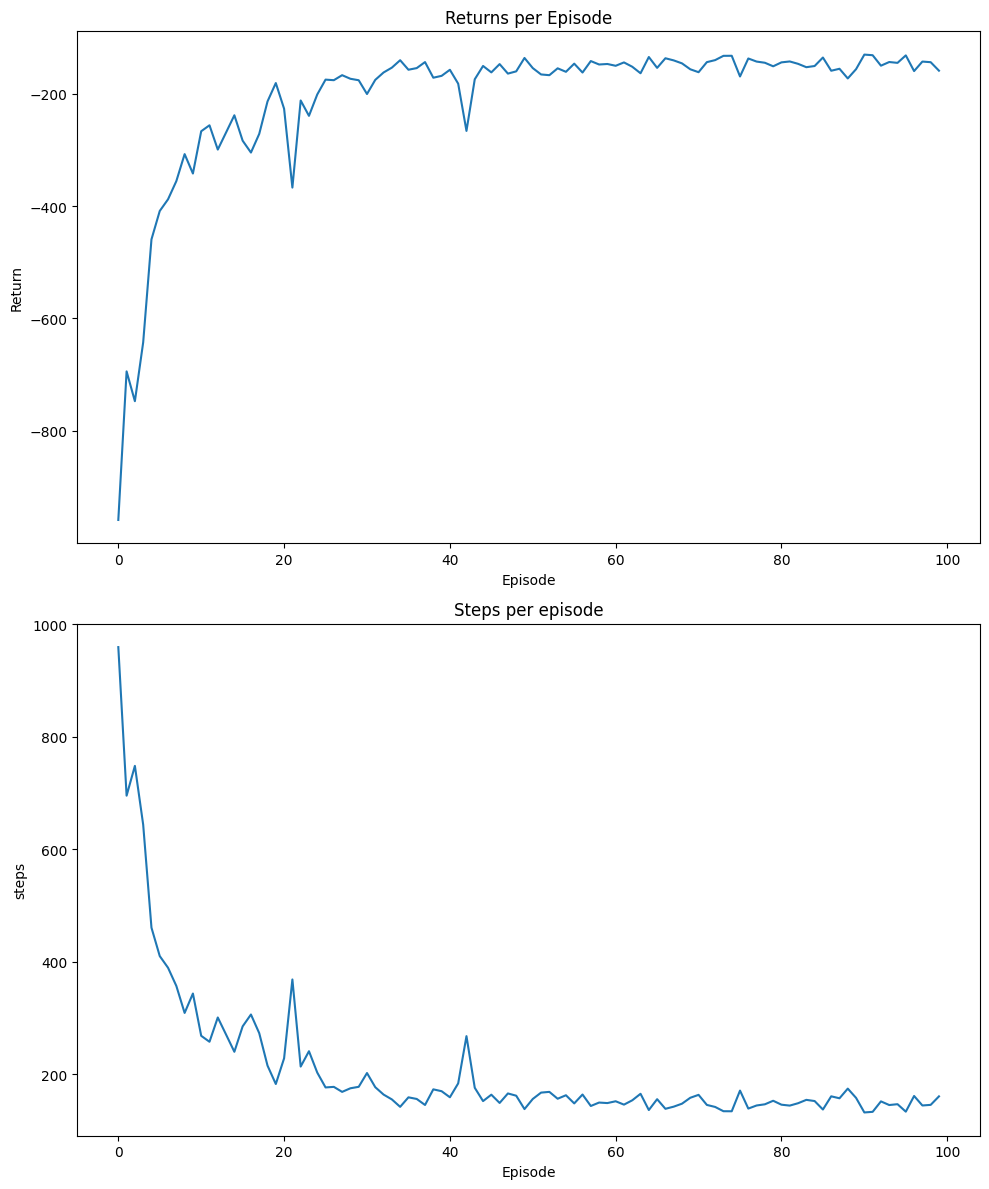

In [26]:
average_and_plot_results(avg_reward_per_episode, avg_steps_per_episode)

### Min Steps

In [29]:
min(avg_steps_per_episode)

131.7

In [31]:
avg_steps_per_episode[-1]

160.3

### Maximum Reward

In [32]:
max(avg_reward_per_episode)

-130.7